## Conscious perception of natural images is constrained by category-related visual features
Daniel Lindh (1,2), Ilja Sligte (2), Sara Assecondi (1), Kimron Shapiro (1), Ian Charest (1)

1 University of Birmingham

2 University of Amsterdam


This notebook contains code for plots generated for this publication

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import spearmanr, ttest_1samp, pearsonr, ttest_rel, wilcoxon
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as smm
import itertools

In [2]:
data_folder = '../data'
CNN_folder = '../DCNN_features'
stats_folder = '../stats_results'
plot_folder = '../plots'
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
AB = np.loadtxt(os.path.join(data_folder, 'ABmag_allsubs.txt'))
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set(style="ticks", font_scale = 2)

## Plot standard AB effect

In [3]:
# Read data, rename columns
df = pd.read_csv(os.path.join(data_folder, 'behavioral_data.csv'))

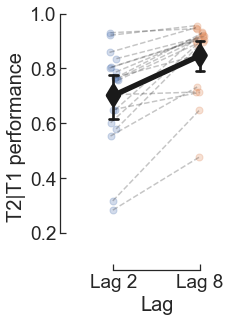

In [26]:
# group data for plotting
df_plot = df.groupby(('subject', 'Lag'), as_index=False).mean()


plt.figure(figsize=(4,5))

# plot individual subjects, with different colors per lag
# and dashed line between subjects
for s in np.unique(df_plot.subject):
    sdf = df_plot[df_plot.subject==s]
    lag2 = sdf[sdf.Lag == 'Lag 2']['HitT2'].values[0]
    lag8 = sdf[sdf.Lag == 'Lag 8']['HitT2'].values[0]

    jitter = (np.random.randint(100)-50)/1000
    markersize=7
    x = (0+jitter, 1+jitter)
    plt.plot(x[0], lag2, color=sns.color_palette()[0], marker='o', alpha=0.25, markersize=markersize)
    plt.plot(x[1], lag8, color=sns.color_palette()[1], marker='o', alpha=0.25, markersize=markersize)
    plt.plot(x, (lag2, lag8), '--k', alpha=0.25)

plt.setp(ax.lines, zorder=100)
# plot mean on top of subjects
ax = sns.pointplot(x='Lag', y='HitT2', color='k',
                   data=df_plot, zorder=1, ci=95,
                   capsize=.1, markers="d", scale=2)
plt.setp(ax.collections, zorder=100, label="")
plt.ylim((0.1, 1.0))
sns.despine(offset=10, trim=True)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.yticks(size=19)
# Set labels
plt.xlabel('Lag', size=20)
plt.ylabel('T2|T1 performance', size=20)
plt.xticks(range(2), ('Lag 2', 'Lag 8'), size=19)

plt.tight_layout()
#plt.show()
save_to = os.path.join(plot_folder, 'Lag_performance.pdf')
plt.savefig(save_to)

## Plot AB effects across categories

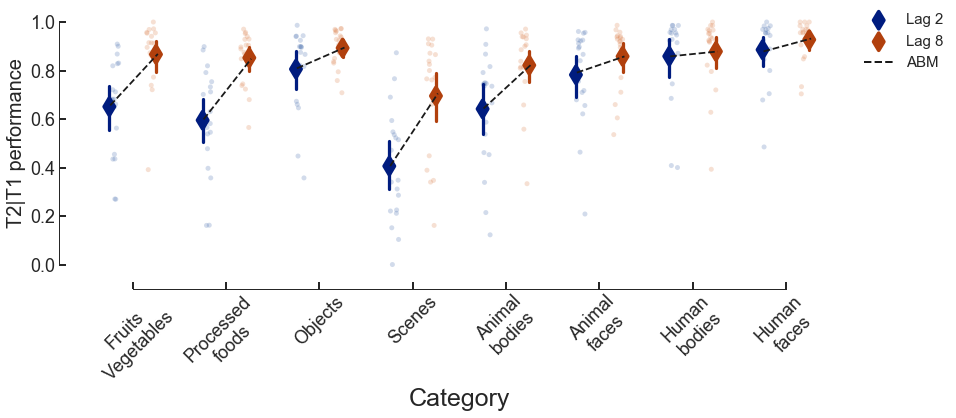

In [58]:
df_plot = df.groupby(('Lag', 'subject', 'Category'), as_index=False).mean()
categories = ('Fruits\nVegetables', 'Processed\nfoods',
              'Objects', 'Scenes', 'Animal\nbodies', 
              'Animal\nfaces', 'Human\nbodies', 'Human\nfaces')
plt.figure(figsize=(14,5))
# Show each observation with a scatterplot
ax = sns.stripplot(x="Category", y="HitT2", hue="Lag",
              data=df_plot, dodge=True, jitter=True,
              alpha=.25, zorder=1, order = categories)
ax.legend_.remove()
# Show the conditional means
ax = sns.pointplot(x="Category", y="HitT2", hue="Lag",
              data=df_plot, dodge=.5, join=False, palette="dark",
              markers="d", scale=1.5, ci=95, order = categories)


# add dashed line between lags
jdf = df.groupby(('Lag', 'Category'), as_index=False).mean()
for i, cat in enumerate(categories):
    # there is an offset to the middle of the diamond, hence -0.025
    lag2 = jdf[(jdf.Category == cat) & (jdf.Lag=='Lag 2')]['HitT2'].values-0.025 
    lag8 = jdf[(jdf.Category == cat) & (jdf.Lag=='Lag 8')]['HitT2'].values-0.025
    x = np.array([-.24, .27]) + i
    if cat == 'Objects' or cat == 'Human\nfaces':
        lag8 += 0.015
    plt.plot(x, (lag2, lag8), '--k')

# Get legends and add our own
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], color='k', lw=2, linestyle='--'))
labels.append('ABM')

# When creating the legend, only use the last elements
# to effectively remove the first two.
l = plt.legend(handles[2:], labels[2:],
               bbox_to_anchor=(1.01, 1), loc=2,
               borderaxespad=0., frameon=False,
               prop={'size': 15})

sns.despine(offset=10, trim=True)

plt.ylabel('T2|T1 performance', size=20)
plt.xlabel('Category', size=25)

plt.xticks(rotation=45, size=18)
plt.yticks(size=18)
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "font_scale": 7, 'linewidth': 10})
plt.tick_params(width=2, length=7)

save_to = os.path.join(plot_folder, 'category_performance.pdf')
plt.savefig(save_to, bbox_inches='tight')

In [140]:
## Save category AB for stats
df_save = df[['subject', 'Category', 'Lag', 'HitT2']]
df_save = df_save.groupby(('subject', 'Category', 'Lag'), as_index=False).mean()
s = ['{0} ({1})'.format(cat, lag).replace('\n', ' ') for cat, lag in zip(df_save['Category'], df_save['Lag'])]
df_save['Condition'] = s
df_save = df_save.groupby(('subject', 'Condition'), as_index=False).mean()
df_save = df_save.pivot(index='subject', columns='Condition', values='HitT2')
df_save.to_csv(os.path.join(data_folder, 'category_lag.csv'), index=False)

## Plot AB for animacy

In [62]:
df_plot = df[df.Category != 'Scenes'].copy()
df_plot['Animate'] = ['Animate' if x > 23 else 'Inanimate' for x in df_plot['T2']]

df_plot = df_plot.groupby(('subject', 'Animate', 'Lag'), as_index=False).mean()

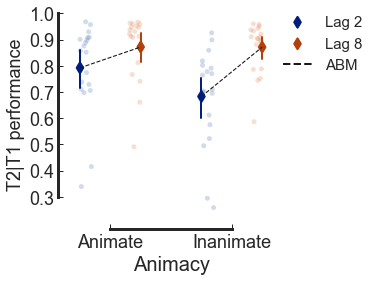

In [147]:

plt.figure(figsize=(4,4))
dodge = 0.5
# Show each observation with a scatterplot
ax = sns.stripplot(x="Animate", y="HitT2", hue="Lag",
              data=df_plot, dodge=dodge/4, jitter=True,
              alpha=.25, zorder=1)
ax.legend_.remove()
# Show the conditional means
ax = sns.pointplot(x="Animate", y="HitT2", hue="Lag",
              data=df_plot, dodge=dodge, join=False, palette="dark",
              markers="d", scale=1.5, ci=95)


# Join between lags
jdf = df_plot.groupby(('Lag', 'Animate'), as_index=False).mean()
for i, cat in enumerate(('Animate','Inanimate')):
    lag2 = jdf[(jdf.Animate == cat) & (jdf.Lag=='Lag 2')]['HitT2'].values
    lag8 = jdf[(jdf.Animate == cat) & (jdf.Lag=='Lag 8')]['HitT2'].values
    x = np.array([-(dodge/2), dodge/2]) + i
    plt.plot(x, (lag2, lag8), '--k')

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], color='k', lw=2, linestyle='--'))
labels.append('ABM')
l = plt.legend(handles[2:], labels[2:],
               bbox_to_anchor=(1.01, 1), loc=2,
               borderaxespad=0., frameon=False,
               prop={'size': 15})


sns.despine(offset=10, trim=True)

plt.ylabel('T2|T1 performance', size=18)
plt.xlabel('Animacy', size=20)

#paper_rc = {'lines.linewidth': 1.2, 'lines.markersize': 10}
#sns.set_context("paper", rc = paper_rc)

sns.set_style({"xtick.direction": "in","ytick.direction": "in", "font_scale": 7})
plt.xticks(size=18)
plt.yticks(size=18)

plt.tight_layout()

save_to = os.path.join(plot_folder, 'animal_performance.pdf')
plt.savefig(save_to, bbox_inches='tight')

In [314]:
## Save category AB for stats
df_save = df_plot[['subject', 'Animate', 'Lag', 'HitT2']]
df_save = df_save.groupby(('subject', 'Animate', 'Lag'), as_index=False).mean()
s = ['{0} ({1})'.format(cat, lag).replace('\n', ' ') for cat, lag in zip(df_save['Animate'], df_save['Lag'])]
df_save['Condition'] = s
df_save = df_save.groupby(('subject', 'Condition'), as_index=False).mean()
df_save = df_save.pivot(index='subject', columns='Condition', values='HitT2')
df_save.to_csv(os.path.join(data_folder, 'Animate_lag.csv'), index=False)

## Plot Mean Absolute Error (MAE) between predicted and actual AB magnitude

In [9]:
df = pd.DataFrame()
for layer in layers:
    print('Layer', layer)
    layer_df = pd.DataFrame()

    errors = []
    for sub in range(AB.shape[0]):
        y_true = AB[sub, :]
        # first iteration is the un-permutated (real) prediction
        perm = glob.glob(os.path.join(data_folder, f'{layer}_prediction.npy'))[0]
        perm = np.load(perm)
        y_pred = perm[sub, :]
        errors.append(MAE(y_true, y_pred))
    layer_df['MAE'] = errors
    layer_df['Layer'] = [layer]*len(layer_df)
    layer_df['Subject'] = np.arange(len(layer_df))

    df = pd.concat((df, layer_df))

# Save for doing stats
df_save = df.pivot(index='Subject', columns='Layer', values='MAE')
df_save.to_csv(os.path.join(data_folder, 'MAE_per_layer.csv'), index=False)

Layer conv1
Layer conv2
Layer conv3
Layer conv4
Layer conv5
Layer fc6
Layer fc7
Layer fc8


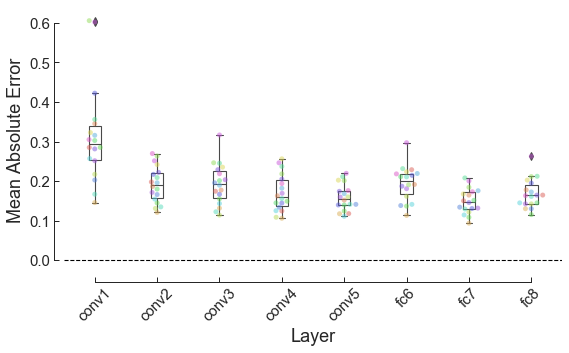

In [10]:
sns.set(style="ticks", font_scale = 2)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
paper_rc = {'lines.linewidth': 1.1, 'lines.markersize': 10}
sns.set_context("paper", rc = paper_rc)
cmap = sns.color_palette("hls", 20)
fig = plt.figure(figsize=(8,5))
# plot
sns.boxplot(x='Layer', y='MAE', data=df, boxprops={'facecolor':'none'}, width=0.2)
ax = sns.swarmplot(x='Layer', y='MAE', hue='Subject', data=df, palette=cmap, edgecolor='black', alpha=0.5)
ax.legend_.remove()

# add horizontal line at 0
plt.axhline(y=0.0, color='black', linestyle='--')
sns.despine(offset=10, trim=True)
#plt.xticks(np.arange(len(layers)), layers, rotation=45, size=15)

#plt.ylim([-0.05, 0.2])
plt.yticks(size=15)
# Set labels
plt.xlabel('Layer', size=18)
plt.ylabel('Mean Absolute Error', size=18)
plt.xticks(size=15, rotation=45)
#plt.title('Correlation between T2 performance and ', size=15)
plt.tight_layout()

# Save
save_to = os.path.join(plot_folder, 'layer_MAE.pdf')
plt.savefig(save_to, bbox_inches='tight')

## Plot fc7 prediction per image

In [4]:
layer = 'fc7'
layer_path = os.path.join(data_folder, f'{layer}_prediction.npy')
y_hat = np.load(layer_path)

# n subjects and images
ns  = AB.shape[0]
ni = AB.shape[1]

df_3 = pd.DataFrame()
for sub in range(ns):
    tmp = pd.DataFrame()
    tmp['subject'] = [f'sub-{sub:02d}']*ni
    tmp['prediction'] = y_hat[sub, :]
    tmp['ABM'] = AB[sub, :]
    tmp['image'] = np.arange(ni)
    
    df_3 = pd.concat((df_3, tmp))

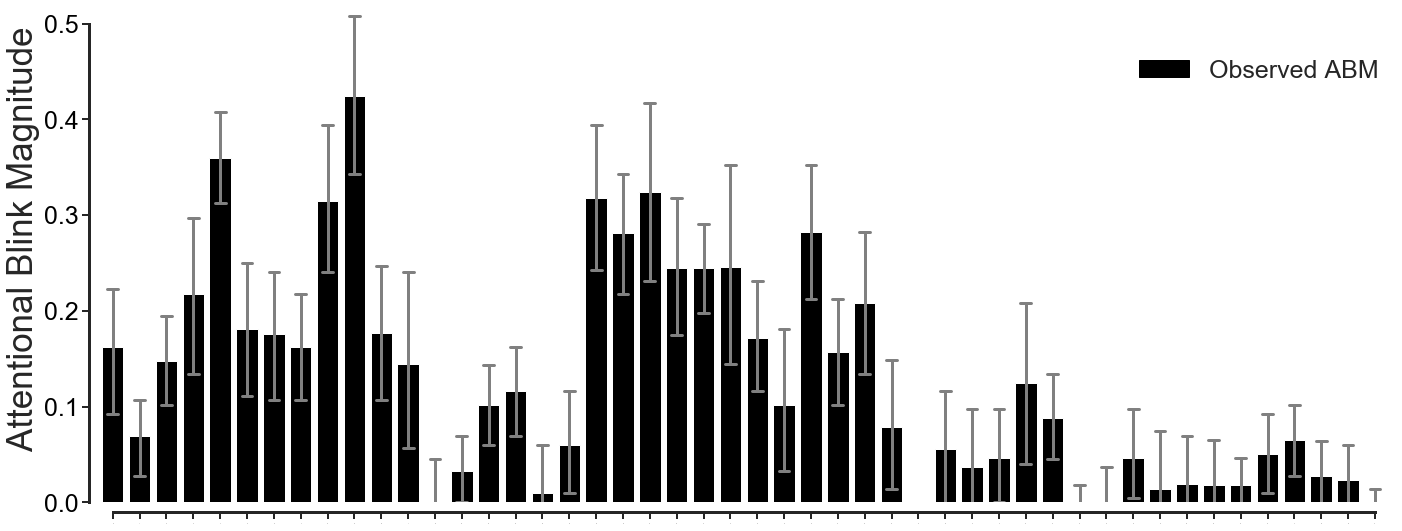

In [8]:
plt.figure(figsize=(20,8))

sns.barplot(x='image', y='ABM', data=df_3, ci=85, color='black', errcolor='grey', errwidth=3, capsize=0.4)

plt.tick_params(width=2, length=7)
#plt.axhline(y=0.0, color='black', linestyle='--')
#plt.xlim(-.5, 47.5)
plt.ylim(-.0, 0.51)
sns.despine(offset=10, trim=True)
plt.xticks(size=0)
plt.yticks(size=25, color='black')
plt.xlabel('')
plt.ylabel('    Attentional Blink Magnitude', size=35)
plt.rcParams['axes.linewidth'] = 3

# Lets add legends
black_patch = mpatches.Patch(color='black')
handles = [Line2D([0], [0], color='r', lw=0, linestyle='-'), black_patch]
labels =['', 'Observed ABM']


l = plt.legend(handles, labels, loc=1,
               borderaxespad=0., frameon=False,
               prop={'size': 25})

plt.tight_layout()

save_to = os.path.join(plot_folder, 'fc_ABM_pred_noline.pdf')
plt.savefig(save_to, bbox_inches='tight')

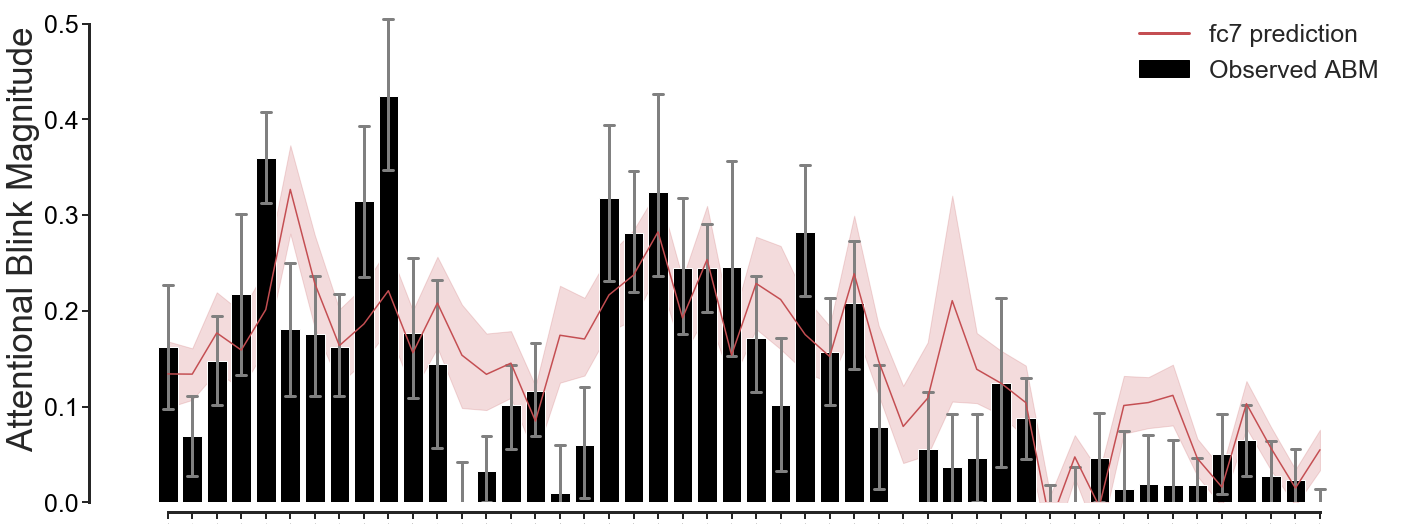

In [6]:
plt.figure(figsize=(20,8))

sns.barplot(x='image', y='ABM', data=df_3, ci=85, color='black', errcolor='grey', errwidth=3, capsize=0.4)
sns.lineplot(x='image', y='prediction', data=df_3, ci=85, markers='d', color ='r')

plt.tick_params(width=2, length=7)
#plt.axhline(y=0.0, color='black', linestyle='--')
#plt.xlim(-.5, 47.5)
plt.ylim(-.0, 0.51)
sns.despine(offset=10, trim=True)
plt.xticks(size=0)
plt.yticks(size=25, color='black')
plt.xlabel('')
plt.ylabel('    Attentional Blink Magnitude', size=35)
plt.rcParams['axes.linewidth'] = 3

# Lets add legends
black_patch = mpatches.Patch(color='black')
handles = [Line2D([0], [0], color='r', lw=3, linestyle='-'), black_patch]
labels =['fc7 prediction', 'Observed ABM']


l = plt.legend(handles, labels, loc=1,
               borderaxespad=0., frameon=False,
               prop={'size': 25})

plt.tight_layout()

save_to = os.path.join(plot_folder, 'fc_ABM_pred.pdf')
#plt.savefig(save_to, bbox_inches='tight')

r = 0.681
r2 = 0.463


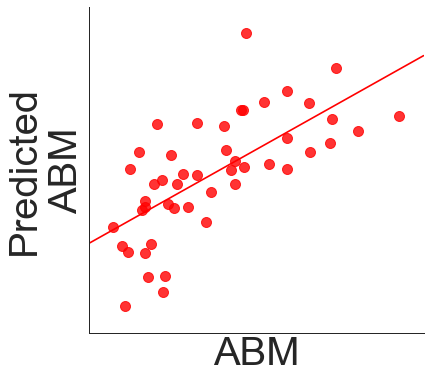

In [26]:
tmp = df_3.groupby(('image'), as_index=False).mean()

paper_rc = {'lines.linewidth': 1.1, 'lines.markersize': 10}
sns.set_context("paper", rc = paper_rc)

plt.figure(figsize=(6,6))
sns.regplot(x='ABM', y='prediction', data=tmp, color='red', ci=None)

sns.set_style({"xtick.direction": "in","ytick.direction": "in", "font_scale": 15})
sns.despine()

plt.xlabel('ABM', size=40)
plt.ylabel('Predicted\nABM', size=40)
plt.xticks([],size=35)
plt.yticks([], size=35)
# correlate 
r, p = pearsonr(tmp['ABM'], tmp['prediction'])
print(f'r = {r:.3f}\nr2 = {r**2:.3f}')

save_to = os.path.join(plot_folder, 'fc_ABM_pred_linplot.pdf')
plt.savefig(save_to, bbox_inches='tight')

plt.show()

## Plot heatmap for comparison between layers

In [139]:
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
# define possible layer comparisons
combos = list(itertools.combinations(range(8), 2))
alpha = 0.05
method = 'b'
p_vals = np.eye(8)
mean_diff = np.zeros((8,8))
for l1, l2 in combos:
    layerx = df[df.Layer==layers[l1]]['MAE'].values
    layery = df[df.Layer==layers[l2]]['MAE'].values
    t, p = ttest_rel(layerx, layery)
    p_vals[l1, l2] = p
    mean_diff[l1, l2] = layerx.mean()- layery.mean()

methods = 'fdr_i'
pval_raw = p_vals[np.triu_indices(8, 1)].flatten()
p_vals[np.triu_indices(8, 1)] = smm.multipletests(pval_raw, alpha=alpha, method=method)[:2][1]

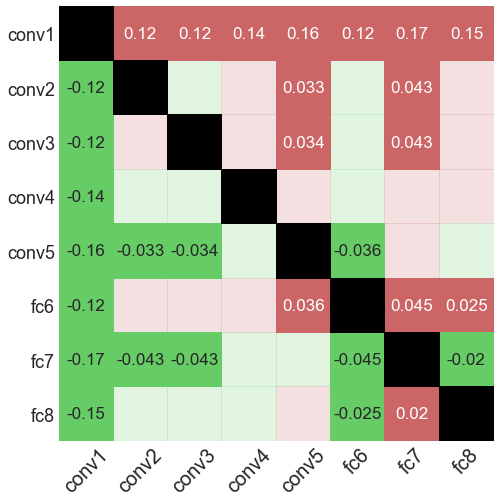

In [141]:
plt.figure(figsize=(10,8))
i_lower = np.tril_indices(8, -1)
i_upper = np.triu_indices(8, 1)

# repeat values of upper triangle on lower triangle
p_vals[i_lower] = p_vals.T[i_lower]
mean_diff[i_lower] = mean_diff.T[i_lower]*-1

# create masks
mask = p_vals > 0.05 #/len(combos) # Bonferroni correct alpha
#mask[i_upper] = True
# the faint color in the background is only masked on the upper triangle
alpha_mask = np.zeros((8,8)).astype(bool)
#alpha_mask[i_upper] = True

# define hot/cold color map
cmap = sns.color_palette("RdBu_r", 2)
cmap = [(0.4, 0.8, 0.4), # green for winning
        (0.8, 0.4, 0.4)] # red for loser

# plot the faint color in the backgroud
ax = sns.heatmap(mean_diff, robust=True, alpha=0.2, cbar=False, square=True,
                 vmin=-0.01, vmax=0.01, cmap=cmap, mask=alpha_mask)
# plot the main results
ax = sns.heatmap(mean_diff , robust=True, cbar=False, vmin=-0.01, square=True,
            vmax=0.01, annot=True, mask=mask, cmap=cmap, annot_kws={"size": 17},
           xticklabels=layers, yticklabels=layers)

# Lets make the diagonal black
cmap = [(0.0, 0.0, 0.0)] # black for the diagonal
sns.heatmap(np.eye(8), robust=True, cbar=False, cmap=cmap, square=True, 
            mask=~np.eye(8).astype(bool), xticklabels=layers, yticklabels=layers)

plt.xticks(rotation=45, size=20)
plt.yticks(rotation=0, size=18)
plt.tick_params(axis='both', which='major', left='off', bottom='off')

save_to = os.path.join(plot_folder, 'layer_MAE_comparison.pdf')
plt.savefig(save_to, bbox_inches='tight')

## Plot heatmap for MAE per participant (saved in stats)

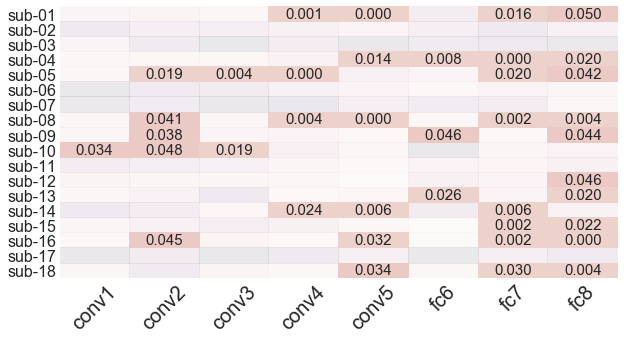

In [105]:
mae = np.load(os.path.join(stats_folder, 'MAE_ABM.npy'))
# these p-values come from the permutation tests
pvals = np.load(os.path.join(stats_folder, 'p_values_ABM.npy'))

layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
subs = ['sub-{0:02d}'.format(x) for x in range(1,19)]
pmask = pvals > 0.05

# set figsize 
plt.figure(figsize=(10,5))
# define color map
cmap = sns.cubehelix_palette(30)

# Plot one low alpha and one masked heatmap
sns.heatmap(pvals, robust=True, alpha=0.1, cbar=False, cmap=cmap)
sns.heatmap(pvals, robust=True, mask=pmask, annot=True, fmt='.3f', annot_kws={"size": 15},
            cbar=False,xticklabels=layers, yticklabels=subs, cmap=cmap)

plt.xticks(rotation=45, size=20)
plt.yticks(rotation=0, size=16)
plt.tick_params(axis='both', which='major', left='off', bottom='off')
plt.show()

/Users/daniel/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


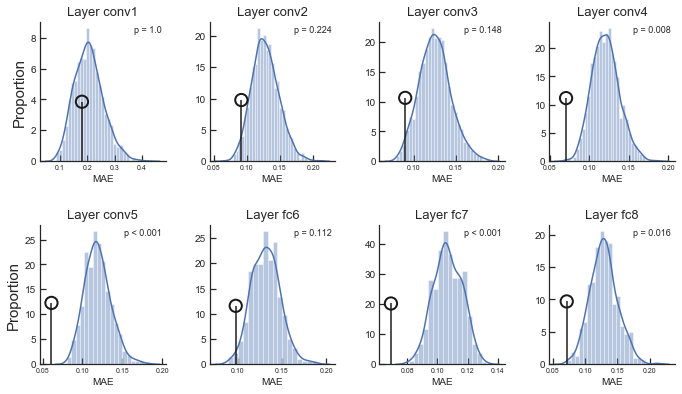

In [5]:
# PERMUTATION TEST DISTRIBUTION
import os
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.lines import Line2D
import pandas as pd

"""
Plots the permutation distribution of MAE per layer
"""

# set plotting styles
sns.set(style="ticks", font_scale = 2)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
paper_rc = {'lines.linewidth': 1.1, 'lines.markersize': 10}

# load data
data_path = '../data'
stats_path = '../stats_results'
AB = np.loadtxt('../data/ABmag_allsubs.txt')
AB_ = AB.mean(0)
layers = ('conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8')
#layers = ['conv1', 'conv2']

# Initiate subplots
fig, axes = plt.subplots(2, 4,sharey=False,sharex=False, figsize=(10,6))
axes = axes.ravel()
p_dict = {}

# array to store MAE values per subject for each layer
MAE_arr = np.zeros((AB.shape[0], len(layers)))
p_arr = np.zeros((AB.shape[0], len(layers)))
M_SE = pd.DataFrame()
for li, layer in enumerate(layers):
    # load layer data for permutations and predictions
    load_path = os.path.join(data_path, f'{layer}_prediction_permutations.npy')
    perm = np.load(load_path)
    load_path = os.path.join(data_path, f'{layer}_prediction.npy')
    sub_pred = np.load(load_path)

    for s in range(AB.shape[0]):
        y = AB[s, :]
        sub_perm = perm[:,s,:]
        pred_mae = MAE(y, sub_pred[s,:])

        mae_list = []
        # iterate over the permutations and get the MAE
        for i in range(sub_perm.shape[0]):
            mae_list.append(MAE(y, sub_perm[i, :]))
        # calculate p-value
        p = sum(pred_mae>mae_list)/sub_perm.shape[0]
        if p < 0.05:
            if f'sub—{s}' not in p_dict.keys():
                p_dict[f'sub—{s}'] = []
            p_dict[f'sub—{s}'].append(layer)
        # store MAE and p-value
        MAE_arr[s, li] = pred_mae
        p_arr[s, li] = p

    # plot distribution of the mean permuted mae across participants
    # for the average ABM
    perm_ = perm.mean(1)
    mae_list = []
    for i in range(perm.shape[0]):
        mae_list.append(MAE(AB_, perm_[i, :]))
    mae_list = np.array(mae_list)

    pred_mae = MAE(AB_, sub_pred.mean(0))
    p = (sum(pred_mae>mae_list)/perm.shape[0])*len(layers)

    mae_std = mae_list.std()
    mae_median = np.mean(mae_list)

    # plot
    sns.distplot(mae_list, ax = axes[li])
    tmp = pd.DataFrame()
    tmp['layer'] = layers
    tmp['STD'] = np.std(mae_list)
    tmp['M'] = np.mean(mae_list)
    M_SE = pd.concat((M_SE, tmp))
    x,y = axes[li].get_lines()[0].get_data()
    axes[li].scatter(pred_mae, max(y)/2, s=150, facecolors='none',
                     edgecolors='k', linewidths=2, zorder=20)
    axes[li].vlines(pred_mae, 0, max(y)/2, zorder=21)

    axes[li].set_xlabel('MAE', size=10)
    if li == 0 or li ==4:
        axes[li].set_ylabel('Proportion', size=15)
    #axes[li].set_ylim((0, 200))

    axes[li].set_title('Layer {0}'.format(layer), size=13)
    #axes[li].set_yticks(size=14)
    axes[li].tick_params(axis='y', which='major', labelsize=10)
    axes[li].tick_params(axis='x', which='major', labelsize=8)

    # add p-value legend
    handles = [Line2D([0], [0], color='k', lw=0)]
    labels = [f'p = {p:.3f}']
    if p > 1:
        labels = ['p = 1.0']
    elif p < 0.001:
        labels = ['p < 0.001']
    l = axes[li].legend(handles, labels, loc=1,
                   borderaxespad=0., frameon=False,
                   prop={'size': 9})
    sns.despine(ax=axes[li])
plt.tight_layout()

# fix x-axes
for i in range(8):
    axes[i].tick_params(axis='x', which='major', bottom='on',
                        top='off', labelbottom='on', labelsize=7)
fig.tight_layout()

# save plot
plt.show()


## Plot CNN target-target similarity and T2 accuracy

In [20]:
# read behavior
df = pd.read_csv(os.path.join(data_folder, 'behavioral_data.csv'))
#lag = 'Lag 2'
#df = df[df.Lag==lag]

In [21]:
#define layers
layers = ['conv1','conv2','conv3','conv4','conv5', 'fc6','fc7','fc8']

df2 = pd.DataFrame()
for sub in np.unique(df.subject):

    print('Working sub:', sub, end='\r')
    tmp = df[df.subject == sub]

    sdf = pd.DataFrame()
    sub_df = pd.DataFrame()
    sub_df['HitT2'] = tmp.HitT2.values
    sub_df['subject'] = [sub]*len(sub_df)
    for layer in layers:
        layer_path = os.path.join(CNN_folder, f'correlated_features_{layer}.npy')
        # load units 
        corr_units = np.load(layer_path)
        
        corr = [corr_units[x-1, y-1] for x,y in zip(tmp.T1,tmp.T2)]
        bins = [np.percentile(corr, x) for x in np.arange(5,100,5)]
        
        sub_df[f'sim_{layer}'] = np.array(corr)
        sub_df[f'bins_{layer}'] = np.digitize(corr, bins)
    
    
    df2 = pd.concat((df2, sub_df))


/Users/daniel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


conv1
T 0.4358609557249856
std 0.2242721571361833
conv2
T 4.903443932813877
std 0.20332818567522837
conv3
T 7.382785838133666
std 0.19962109422306004
conv4
T 4.421087524886304
std 0.1775334114603012
conv5
T 3.6687438816522375
std 0.22926494328901525
fc6
T 5.500561738422472
std 0.2008035776155223
fc7
T 4.321033617470557
std 0.21056929103553498
fc8
T 7.519494707264751
std 0.16699295617755552


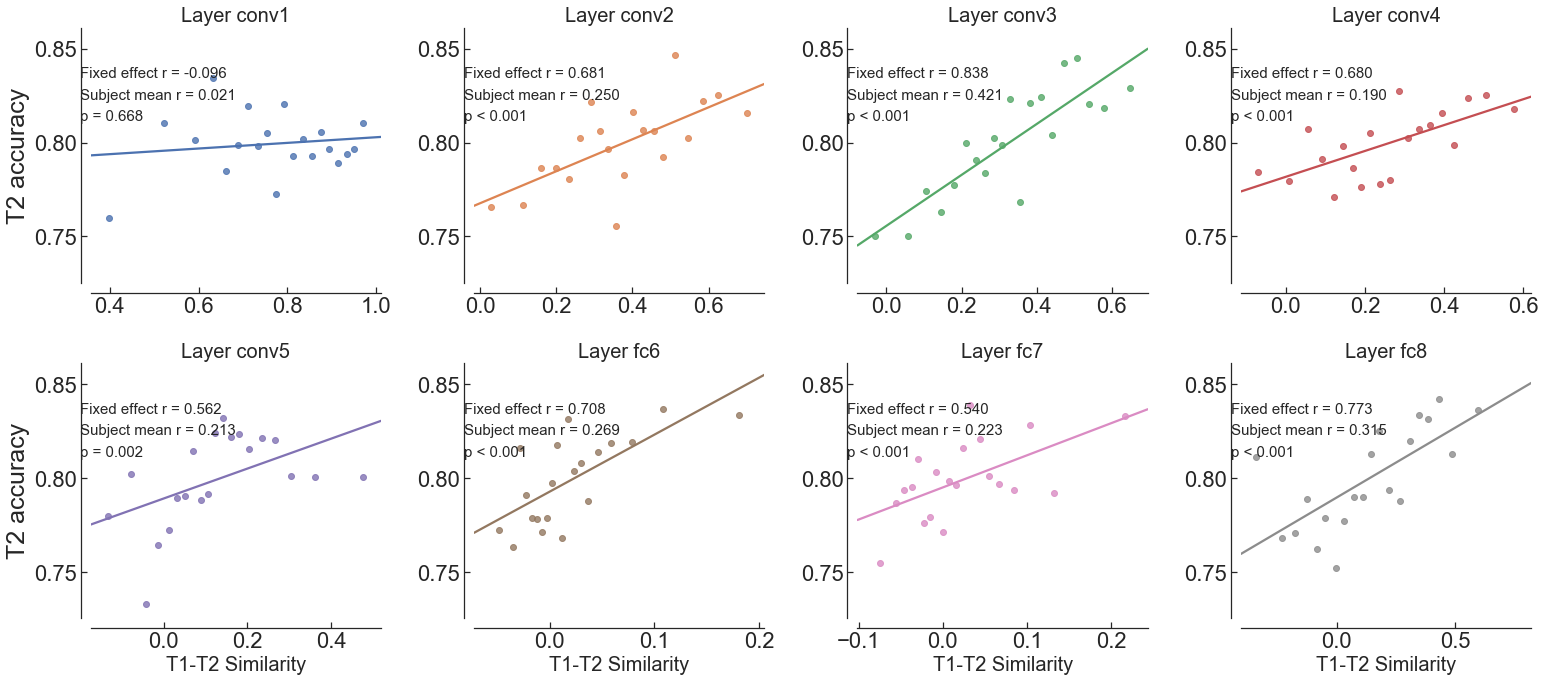

In [22]:
sns.set(style="ticks", font_scale = 2)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
layers = ['conv1','conv2','conv3','conv4','conv5', 'fc6','fc7','fc8', ]
f, ax = plt.subplots(2,4,figsize=(22,10), sharey=True)

ax = ax.ravel()
dframe2 = pd.DataFrame(columns=['subject', 'layer',  'pcorr'])
for x, layer in enumerate(layers):
    
    
    plt_df = df2.groupby(("bins_{0}".format(layer)), as_index=False).mean()
    sns.regplot(x=f"sim_{layer}", y="HitT2", data=plt_df, ax=ax[x], ci=None)
    fr, fp = spearmanr(plt_df[f"sim_{layer}"].values, plt_df["HitT2"].values)
    if x == 0 or x == 4:
        ax[x].set_ylabel('T2 accuracy', size=25)
    else:
        ax[x].set_ylabel('', size=25)
    if x > 3:
        ax[x].set_xlabel('T1-T2 Similarity', size=20)
    else:
        ax[x].set_xlabel('', size=25)
    
    #ax[x].set_xticks(range(1, 21, 5))
    
    # do stats
    df_binned = df2.groupby(("bins_{0}".format(layer), 'subject'), as_index=False).mean()
    r_values = []
    for sub in np.unique(df2.subject):
        tmp = df_binned[df_binned.subject == sub]
        corr  = spearmanr(tmp["sim_{0}".format(layer)], tmp.HitT2)[0]
        r_values.append(corr)
        tmp_df = pd.DataFrame()
        tmp_df['subject'] = [sub]
        tmp_df['layer'] = [x]
        tmp_df['pcorr'] = [corr]
        dframe2 = pd.concat((dframe2, tmp_df))
        
    #ttest
    t, p = ttest_1samp(np.arctanh(r_values), 0)
    ax[x].set_title("Layer {0}".format(layer), size=20)
    print(layer)
    print('T', t)
    # add p-value legend
    handles = [Line2D([0], [0], color='k', lw=0)]*3
    if p < 0.001:
        p_str = f'p < 0.001'
    else:
        p_str = f'p = {p:.3f}'
    rr = np.mean(r_values)
    print('std', np.std(r_values))
    labels = [f'\nFixed effect r = {fr:.3f}',f'Subject mean r = {rr:.3f}', p_str]
    l = ax[x].legend(handles, labels, loc=3,
                    bbox_to_anchor=(-.2, 0.6),
                   borderaxespad=0., frameon=False,
                   prop={'size': 15})
    #ax[x].set_ylim(0.3, 1)
    sns.despine(offset=10, ax=ax[x])
#sns.despine()
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.tight_layout()


save_to = os.path.join(plot_folder, f'layer_target_similiarty_T2_{lag}.pdf')
plt.savefig(save_to, bbox_inches='tight')


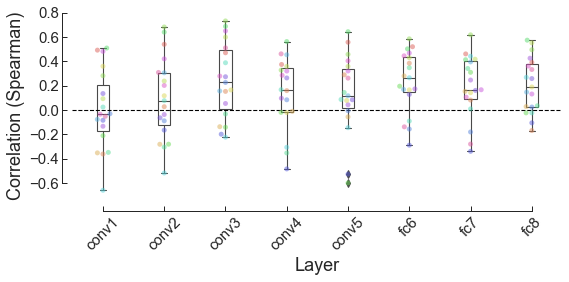

In [30]:
sns.set(style="ticks", font_scale = 2)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
paper_rc = {'lines.linewidth': 1.1, 'lines.markersize': 10}
sns.set_context("paper", rc = paper_rc)
cmap = sns.color_palette("hls", 20)

plt.figure(figsize=(8,4))

# plot
sns.boxplot(x='layer', y='pcorr', data=dframe2, boxprops={'facecolor':'none'}, width=0.2)
ax = sns.swarmplot(x='layer', y='pcorr', hue='subject',
                   data=dframe2, palette=cmap, edgecolor='black',
                   alpha=0.5)
ax.legend_.remove()
# add horizontal line at 0
plt.axhline(y=0.0, color='black', linestyle='--')
sns.despine(offset=10, trim=True)

#plt.ylim([-.8, .61])
plt.yticks(size=15)
# Set labels
plt.xlabel('Layer', size=18)
plt.ylabel('Correlation (Spearman)', size=18)
plt.xticks(range(8), layers, size=15, rotation=45)

#plt.title('Correlation between T2 performance and ', size=15)
plt.tight_layout()

# Save
save_to = os.path.join(plot_folder, f'layer_subject_target_similiarty_T2_{lag}.pdf')
plt.savefig(save_to, bbox_inches='tight')

In [212]:
# Save for stats
df_save = dframe2.pivot(index='subject', columns='layer', values='pcorr')
df_save.to_csv(os.path.join(data_folder, 't-t_t2_accuracy_corr.csv'), index=False)

## Plot heatmap of layer comparisons 

In [213]:
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
# define possible layer comparisons
combos = list(itertools.combinations(range(8), 2))

p_vals = np.eye(8)
mean_diff = np.zeros((8,8))
for l1, l2 in combos:
    layerx = df_save[l1].values
    layery = df_save[l2].values
    t, p = ttest_rel(np.arctanh(layerx), np.arctanh(layery))
    p_vals[l1, l2] = p
    mean_diff[l1, l2] = layerx.mean()- layery.mean()

methods = 'b'
pval_raw = p_vals[np.triu_indices(8, 1)].flatten()
p_vals[np.triu_indices(8, 1)] = smm.multipletests(pval_raw, alpha=alpha, method=method)[:2][1]

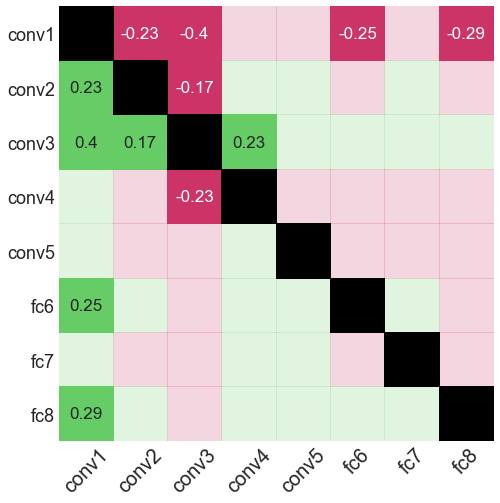

In [214]:
plt.figure(figsize=(10,8))
i_lower = np.tril_indices(8, -1)
i_upper = np.triu_indices(8, 1)

# repeat values of upper triangle on lower triangle
p_vals[i_lower] = p_vals.T[i_lower]
mean_diff[i_lower] = mean_diff.T[i_lower]*-1

# create masks
mask = p_vals > 0.05 #/len(combos) # Bonferroni correct alpha
#mask[i_upper] = True
# the faint color in the background is only masked on the upper triangle
alpha_mask = np.zeros((8,8)).astype(bool)
#alpha_mask[i_upper] = True

# define hot/cold color map
cmap = sns.color_palette("RdBu_r", 2)
cmap = [(0.8, 0.2, 0.4), # green for winning
        (0.4, 0.8, 0.4)] # red for loser

# plot the faint color in the backgroud
ax = sns.heatmap(mean_diff, robust=True, alpha=0.2, cbar=False, square=True,
                 vmin=-0.01, vmax=0.01, cmap=cmap, mask=alpha_mask)
# plot the main results
ax = sns.heatmap(mean_diff , robust=True, cbar=False, vmin=-0.01, square=True,
            vmax=0.01, annot=True, mask=mask, cmap=cmap, annot_kws={"size": 17},
           xticklabels=layers, yticklabels=layers)

# Lets make the diagonal black
cmap = [(0.0, 0.0, 0.0)] # black for the diagonal
sns.heatmap(np.eye(8), robust=True, cbar=False, cmap=cmap, square=True, 
            mask=~np.eye(8).astype(bool), xticklabels=layers, yticklabels=layers)

plt.xticks(rotation=45, size=20)
plt.yticks(rotation=0, size=18)
plt.tick_params(axis='both', which='major', left='off', bottom='off')

# Save
save_to = os.path.join(plot_folder, 'layer_comparison_target_similiarty_T2.pdf')
plt.savefig(save_to, bbox_inches='tight')